# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  2408k      0  0:01:09  0:01:09 --:--:-- 2787k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

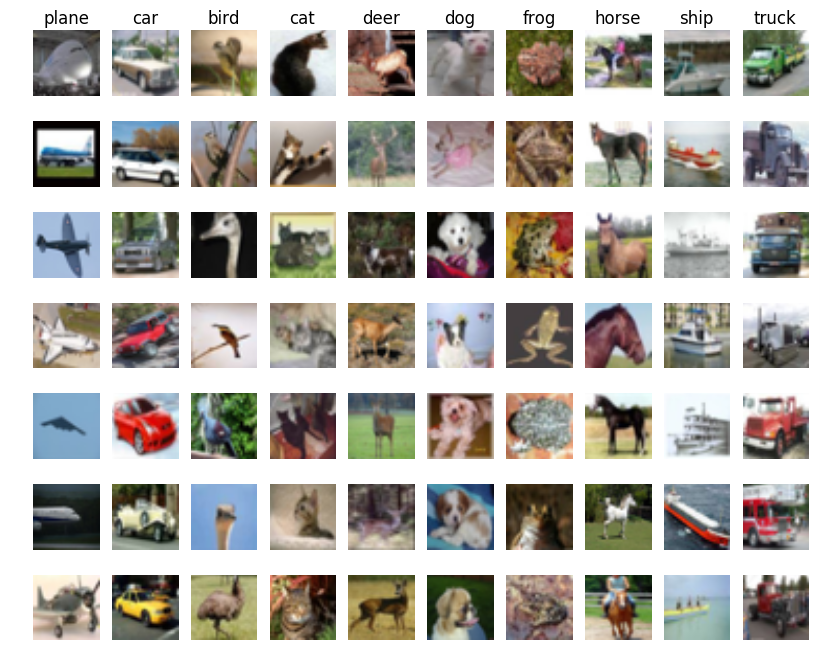

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
X_train = np.rollaxis(X_train, 3, 1).astype(np.float32)
X_test = np.rollaxis(X_test, 3, 1).astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_train.shape

(50000, 3, 32, 32)

In [6]:
indices = np.random.permutation(len(X_train))
old_X_train = np.copy(X_train)
old_y_train = np.copy(y_train)
X_train = np.array([old_X_train[index] for index in indices])
y_train = np.array([old_y_train[index] for index in indices])
del old_X_train
del old_y_train

In [7]:
X_val = X_train[-1000:]
y_val = y_train[-1000:]
X_train = X_train[:-1000]
y_train = y_train[:-1000]

In [8]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5105)


Так задаётся архитектура нейронки

In [58]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)
#input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)


conv11 = lasagne.layers.Conv2DLayer(input_layer, num_filters=32, filter_size=(3, 3),
                                   nonlinearity=lasagne.nonlinearities.rectify, pad="same",
                                   W=lasagne.init.GlorotNormal(), b=lasagne.init.Constant(0.1),
                                   name="conv11")

conv12 = lasagne.layers.Conv2DLayer(conv11, num_filters=32, filter_size=(3, 3),
                                   nonlinearity=lasagne.nonlinearities.rectify, pad="same",
                                   W=lasagne.init.GlorotNormal(), b=lasagne.init.Constant(0.1),
                                   name="conv12")

pool1 = lasagne.layers.MaxPool2DLayer(conv12, pool_size=(2, 2), name="pool1")

conv21 = lasagne.layers.Conv2DLayer(pool1, num_filters=64, filter_size=(3, 3),
                                   nonlinearity=lasagne.nonlinearities.rectify, pad="same",
                                   W=lasagne.init.GlorotNormal(), b=lasagne.init.Constant(0.1),
                                   name="conv21")

conv22 = lasagne.layers.Conv2DLayer(conv21, num_filters=64, filter_size=(3, 3),
                                   nonlinearity=lasagne.nonlinearities.rectify, pad="same",
                                   W=lasagne.init.GlorotNormal(), b=lasagne.init.Constant(0.1),
                                   name="conv22")

pool2 = lasagne.layers.MaxPool2DLayer(conv22, pool_size=(2, 2), name="pool2")

conv31 = lasagne.layers.Conv2DLayer(lasagne.layers.dropout(pool2, p=.25), num_filters=128, filter_size=(3, 3),
                                   nonlinearity=lasagne.nonlinearities.rectify, pad="same",
                                   W=lasagne.init.GlorotNormal(), b=lasagne.init.Constant(0.1),
                                   name="conv31")

conv32 = lasagne.layers.Conv2DLayer(conv31, num_filters=128, filter_size=(3, 3),
                                   nonlinearity=lasagne.nonlinearities.rectify, pad="same",
                                   W=lasagne.init.GlorotNormal(), b=lasagne.init.Constant(0.1),
                                   name="conv32")

pool3 = lasagne.layers.MaxPool2DLayer(conv32, pool_size=(2, 2), name="pool3")

fc1 = lasagne.layers.DenseLayer(lasagne.layers.dropout(pool3, p=.5),
                                num_units=2048,
                                nonlinearity=lasagne.nonlinearities.rectify,
                                W=lasagne.init.GlorotNormal(),
                                b=lasagne.init.Constant(0.1),
                                name="fc1")

# fc2 = lasagne.layers.DenseLayer(lasagne.layers.dropout(fc1, p=.5),
#                                 num_units=2048,
#                                 nonlinearity=lasagne.nonlinearities.rectify,
#                                 W=lasagne.init.Normal(std=0.1),
#                                 name="fc2")

dense_output = lasagne.layers.DenseLayer(lasagne.layers.dropout(fc1, p=.4),
                                         num_units=10,
                                         nonlinearity=lasagne.nonlinearities.softmax, 
                                         W=lasagne.init.GlorotNormal(),
                                         b=lasagne.init.Constant(0.1),
                                         name="output")


In [59]:
#предсказание нейронки (theano-преобразование)
y_predicted_train = lasagne.layers.get_output(dense_output, deterministic=False)
y_predicted = lasagne.layers.get_output(dense_output, deterministic=True)

In [60]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print(all_weights)

[conv11.W, conv11.b, conv12.W, conv12.b, conv21.W, conv21.b, conv22.W, conv22.b, conv31.W, conv31.b, conv32.W, conv32.b, fc1.W, fc1.b, output.W, output.b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [61]:
#функция ошибки - средняя кроссэнтропия
loss_train = lasagne.objectives.categorical_crossentropy(y_predicted_train,target_y).mean()
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#<возможно добавить регуляризатор>

accuracy_train = lasagne.objectives.categorical_accuracy(y_predicted_train,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adam(loss_train, all_weights,learning_rate=0.0001)
                

In [62]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss_train,accuracy_train],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [63]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [64]:
import time

num_epochs = 60 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 60 took 23.610s
  training loss (in-iteration):		2.027393
  train accuracy:		31.86 %
  validation accuracy:		43.60 %
Epoch 2 of 60 took 24.152s
  training loss (in-iteration):		1.475434
  train accuracy:		45.88 %
  validation accuracy:		52.40 %
Epoch 3 of 60 took 23.735s
  training loss (in-iteration):		1.309313
  train accuracy:		52.69 %
  validation accuracy:		55.60 %
Epoch 4 of 60 took 23.902s
  training loss (in-iteration):		1.198210
  train accuracy:		56.86 %
  validation accuracy:		60.00 %
Epoch 5 of 60 took 24.681s
  training loss (in-iteration):		1.107837
  train accuracy:		60.71 %
  validation accuracy:		62.40 %
Epoch 6 of 60 took 25.036s
  training loss (in-iteration):		1.028142
  train accuracy:		63.38 %
  validation accuracy:		65.50 %
Epoch 7 of 60 took 24.959s
  training loss (in-iteration):		0.959247
  train accuracy:		65.97 %
  validation accuracy:		65.10 %
Epoch 8 of 60 took 25.334s
  training loss (in-iteration):		0.913320
  train accuracy:		67.77 %
  valida

In [67]:
#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.sgd(loss_train, all_weights,learning_rate=0.00002)

#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss_train,accuracy_train],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [68]:
num_epochs = 80 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(60, num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 61 of 80 took 20.474s
  training loss (in-iteration):		0.161050
  train accuracy:		94.32 %
  validation accuracy:		80.90 %
Epoch 62 of 80 took 20.788s
  training loss (in-iteration):		0.154046
  train accuracy:		94.61 %
  validation accuracy:		80.80 %
Epoch 63 of 80 took 20.364s
  training loss (in-iteration):		0.151949
  train accuracy:		94.59 %
  validation accuracy:		81.20 %
Epoch 64 of 80 took 20.511s
  training loss (in-iteration):		0.151050
  train accuracy:		94.72 %
  validation accuracy:		80.80 %
Epoch 65 of 80 took 20.336s
  training loss (in-iteration):		0.150342
  train accuracy:		94.74 %
  validation accuracy:		80.90 %
Epoch 66 of 80 took 20.697s
  training loss (in-iteration):		0.146358
  train accuracy:		94.84 %
  validation accuracy:		81.40 %
Epoch 67 of 80 took 20.198s
  training loss (in-iteration):		0.142051
  train accuracy:		94.99 %
  validation accuracy:		81.70 %
Epoch 68 of 80 took 20.411s
  training loss (in-iteration):		0.146840
  train accuracy:		94.81 %


In [69]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		82.63 %
Achievement unlocked: колдун 80 уровня


## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3